<a href="https://colab.research.google.com/github/hendrikyong/CVNL_Assignment_1/blob/main/CVNL_RNN_(10).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import nltk
from nltk.tokenize import word_tokenize
import requests
import json
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

nltk.download("punkt")
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
# get json dataset from github
url = "https://raw.githubusercontent.com/snipsco/nlu-benchmark/master/2016-12-built-in-intents/benchmark_data.json"
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    print("Successfully fetched SNIPS dataset")

    # Extract intents and associated text queries
    snips_data = {}
    for domain in data["domains"]:
        for intent in domain["intents"]:
            intent_name = intent["benchmark"]["Snips"]["original_intent_name"]
            queries = [query["text"] for query in intent["queries"]]
            snips_data[intent_name] = queries

    print(f"Total intents: {len(snips_data)}")
    print("Example intent:", list(snips_data.keys())[0])
    print("Example queries:", snips_data[list(snips_data.keys())[0]][:5])
else:
    print("Failed to fetch SNIPS dataset")

Successfully fetched SNIPS dataset
Total intents: 10
Example intent: ShareCurrentLocation
Example queries: ["Share my location with Hillary's sister", 'Send my current location to my father', 'Share my current location with Jim', 'Send my location to my husband', 'Send my location']


In [3]:
all_words = [word for queries in snips_data.values() for query in queries for word in word_tokenize(query.lower())]

# build vocabulary
vocab = {word: idx + 2 for idx, word in enumerate(Counter(all_words))}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

# map intent
intent_labels = {intent: idx for idx, intent in enumerate(snips_data.keys())}

def text_to_sequence(text, vocab, max_len=10):
    tokens = [vocab.get(word, vocab["<UNK>"]) for word in word_tokenize(text.lower())]
    return tokens[:max_len] + [vocab["<PAD>"]] * (max_len - len(tokens))

sample_text = "play some jazz music"
print(text_to_sequence(sample_text, vocab))


[1, 257, 212, 1, 0, 0, 0, 0, 0, 0]


In [4]:
class SNIPSDataset(torch.utils.data.Dataset):
    def __init__(self, data, vocab, intent_labels, max_len=10):
        self.data = data
        self.vocab = vocab
        self.intent_labels = intent_labels
        self.max_len = max_len
        self.samples = [(query, intent) for intent, queries in data.items() for query in queries]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        text, intent = self.samples[idx]
        tokenized_text = text_to_sequence(text, self.vocab, self.max_len)
        label = self.intent_labels[intent]
        return torch.tensor(tokenized_text), torch.tensor(label)

# create dataset, split into test and evaluation
full_dataset = SNIPSDataset(snips_data, vocab, intent_labels)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [24]:
class IntentBiRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers=1, dropout=0.5):
        super(IntentBiRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x, lengths):
        x_embedded = self.embedding(x)

        # pack
        x_packed = torch.nn.utils.rnn.pack_padded_sequence(x_embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.rnn(x_packed)

        # extract last hidden state for both directions
        hidden = hidden.view(self.rnn.num_layers, 2, x.size(0), self.rnn.hidden_size)
        hidden = torch.cat((hidden[-1, 0], hidden[-1, 1]), dim=1)

        return self.fc(hidden)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = IntentBiRNN(len(vocab), embed_dim=64, hidden_dim=32, output_dim=len(intent_labels)).to(device)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [29]:
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-3)
criterion = nn.CrossEntropyLoss()

num_epochs = 20

train_losses, train_accuracies, val_losses = [], [], []

# Training loop without validation after each epoch
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
        for texts, labels in pbar:
            texts, labels = texts.to(device), labels.to(device)
            lengths = (texts != vocab["<PAD>"]).sum(dim=1).cpu()

            optimizer.zero_grad()
            outputs = model(texts, lengths)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            correct_train += (predictions == labels).sum().item()
            total_train += labels.size(0)

            pbar.set_postfix(Loss=f"{loss.item():.4f}")

    train_losses.append(total_train_loss / len(train_loader))
    train_accuracies.append(100.0 * correct_train / total_train)

    print(f"Epoch {epoch+1}:")
    print(f"  Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%")

# Perform validation after all epochs
model.eval()
total_val_loss = 0
correct_val = 0
total_val = 0

with torch.no_grad():
    for texts, labels in val_loader:
        texts, labels = texts.to(device), labels.to(device)
        lengths = (texts != vocab["<PAD>"]).sum(dim=1).cpu()

        outputs = model(texts, lengths)
        loss = criterion(outputs, labels)

        total_val_loss += loss.item()

        predictions = torch.argmax(outputs, dim=1)
        correct_val += (predictions == labels).sum().item()
        total_val += labels.size(0)

val_loss = total_val_loss / len(val_loader)
val_losses.append(val_loss)
val_accuracy = 100.0 * correct_val / total_val

print("Final Validation Results:")
print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")


Epoch 1/20: 100%|██████████| 9/9 [00:00<00:00, 102.26batch/s, Loss=1.2169]


Epoch 1:
  Train Loss: 1.2177, Train Accuracy: 69.85%


Epoch 2/20: 100%|██████████| 9/9 [00:00<00:00, 122.81batch/s, Loss=0.8393]


Epoch 2:
  Train Loss: 1.0897, Train Accuracy: 74.05%


Epoch 3/20: 100%|██████████| 9/9 [00:00<00:00, 120.29batch/s, Loss=1.1034]


Epoch 3:
  Train Loss: 1.0420, Train Accuracy: 74.43%


Epoch 4/20: 100%|██████████| 9/9 [00:00<00:00, 102.27batch/s, Loss=0.7504]


Epoch 4:
  Train Loss: 0.9459, Train Accuracy: 75.57%


Epoch 5/20: 100%|██████████| 9/9 [00:00<00:00, 96.54batch/s, Loss=0.9457]


Epoch 5:
  Train Loss: 0.9068, Train Accuracy: 77.48%


Epoch 6/20: 100%|██████████| 9/9 [00:00<00:00, 106.54batch/s, Loss=0.7563]


Epoch 6:
  Train Loss: 0.8349, Train Accuracy: 81.30%


Epoch 7/20: 100%|██████████| 9/9 [00:00<00:00, 103.98batch/s, Loss=0.5280]


Epoch 7:
  Train Loss: 0.7647, Train Accuracy: 83.21%


Epoch 8/20: 100%|██████████| 9/9 [00:00<00:00, 105.35batch/s, Loss=0.7779]


Epoch 8:
  Train Loss: 0.7408, Train Accuracy: 85.11%


Epoch 9/20: 100%|██████████| 9/9 [00:00<00:00, 108.30batch/s, Loss=0.6591]


Epoch 9:
  Train Loss: 0.6864, Train Accuracy: 86.26%


Epoch 10/20: 100%|██████████| 9/9 [00:00<00:00, 97.21batch/s, Loss=0.6105]


Epoch 10:
  Train Loss: 0.6418, Train Accuracy: 88.17%


Epoch 11/20: 100%|██████████| 9/9 [00:00<00:00, 83.75batch/s, Loss=1.0522]


Epoch 11:
  Train Loss: 0.6404, Train Accuracy: 90.46%


Epoch 12/20: 100%|██████████| 9/9 [00:00<00:00, 85.08batch/s, Loss=0.6081]


Epoch 12:
  Train Loss: 0.5640, Train Accuracy: 92.37%


Epoch 13/20: 100%|██████████| 9/9 [00:00<00:00, 84.46batch/s, Loss=0.3891]


Epoch 13:
  Train Loss: 0.5110, Train Accuracy: 92.37%


Epoch 14/20: 100%|██████████| 9/9 [00:00<00:00, 84.57batch/s, Loss=1.0138]


Epoch 14:
  Train Loss: 0.5343, Train Accuracy: 93.51%


Epoch 15/20: 100%|██████████| 9/9 [00:00<00:00, 94.06batch/s, Loss=0.3446]


Epoch 15:
  Train Loss: 0.4447, Train Accuracy: 93.89%


Epoch 16/20: 100%|██████████| 9/9 [00:00<00:00, 92.39batch/s, Loss=0.3976]


Epoch 16:
  Train Loss: 0.4207, Train Accuracy: 94.66%


Epoch 17/20: 100%|██████████| 9/9 [00:00<00:00, 89.86batch/s, Loss=0.2235]


Epoch 17:
  Train Loss: 0.3801, Train Accuracy: 95.80%


Epoch 18/20: 100%|██████████| 9/9 [00:00<00:00, 89.44batch/s, Loss=0.3779]


Epoch 18:
  Train Loss: 0.3692, Train Accuracy: 96.18%


Epoch 19/20: 100%|██████████| 9/9 [00:00<00:00, 89.01batch/s, Loss=0.1968]


Epoch 19:
  Train Loss: 0.3289, Train Accuracy: 96.95%


Epoch 20/20: 100%|██████████| 9/9 [00:00<00:00, 91.44batch/s, Loss=0.1695]


Epoch 20:
  Train Loss: 0.3060, Train Accuracy: 97.71%
Final Validation Results:
  Val Loss: 0.7530, Val Accuracy: 66.67%


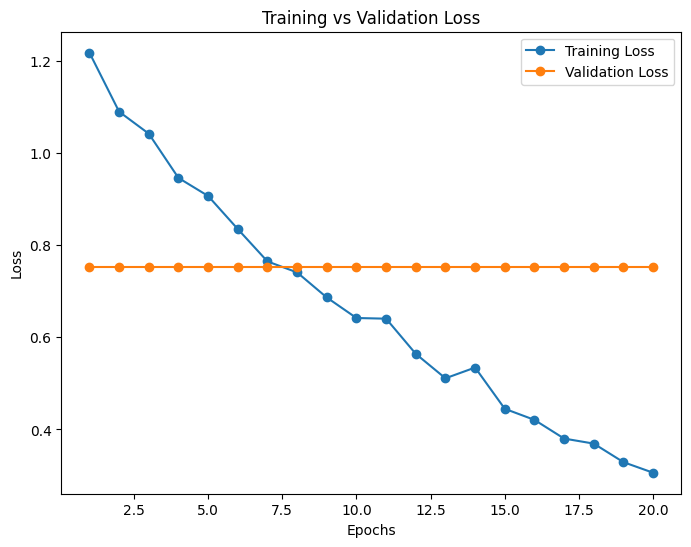

In [30]:
plt.figure(figsize=(8, 6))
epochs = range(1, len(train_losses) + 1)
if len(val_losses) < len(train_losses):
    val_losses.extend([val_losses[-1]] * (len(train_losses) - len(val_losses)))
plt.plot(epochs, train_losses, label="Training Loss", marker='o')
plt.plot(epochs, val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


In [31]:
def predict_intent(text, model, vocab, intent_labels):
    model.eval()

    tokenized = text_to_sequence(text, vocab)
    input_tensor = torch.tensor(tokenized).unsqueeze(0).to(device)
    length = torch.tensor([len(tokenized)], dtype=torch.int64).cpu()

    with torch.no_grad():
        output = model(input_tensor, length)
        predicted_label_idx = torch.argmax(output, dim=1).item()
    predicted_label = [key for key, value in intent_labels.items() if value == predicted_label_idx][0]
    return predicted_label

print(predict_intent("play some music", model, vocab, intent_labels))
print(predict_intent("turn on the lights", model, vocab, intent_labels))
print(predict_intent("book a flight to New York", model, vocab, intent_labels))


BookRestaurant
BookRestaurant
RequestRide


In [32]:
# Import necessary libraries
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

def generate_rnn_classification_report(model, dataloader, device, class_names):
    """
    Evaluates the RNN model using accuracy, precision, recall, and F1-score.
    """
    model.eval()  # Set model to evaluation mode
    y_true, y_pred = [], []

    with torch.no_grad():
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)
            lengths = (texts != vocab["<PAD>"]).sum(dim=1).cpu()  # Get actual lengths

            # Get model predictions
            outputs = model(texts, lengths)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Print evaluation results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

# Define class names from the SNIPS dataset
class_names = list(intent_labels.keys())

# Call the classification report function
generate_rnn_classification_report(model, val_loader, device, class_names)


Classification Report:
                       precision    recall  f1-score   support

 ShareCurrentLocation       0.67      0.67      0.67         3
        ComparePlaces       0.20      1.00      0.33         1
      GetPlaceDetails       0.42      0.50      0.45        10
          SearchPlace       0.67      0.40      0.50         5
       BookRestaurant       0.65      1.00      0.79        11
          RequestRide       0.80      0.80      0.80         5
        GetDirections       1.00      0.78      0.88         9
             ShareETA       0.83      0.83      0.83         6
GetTrafficInformation       0.00      0.00      0.00         5
           GetWeather       0.88      0.64      0.74        11

             accuracy                           0.67        66
            macro avg       0.61      0.66      0.60        66
         weighted avg       0.67      0.67      0.65        66

Accuracy: 0.6667
Precision: 0.6734
Recall: 0.6667
F1-Score: 0.6515


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

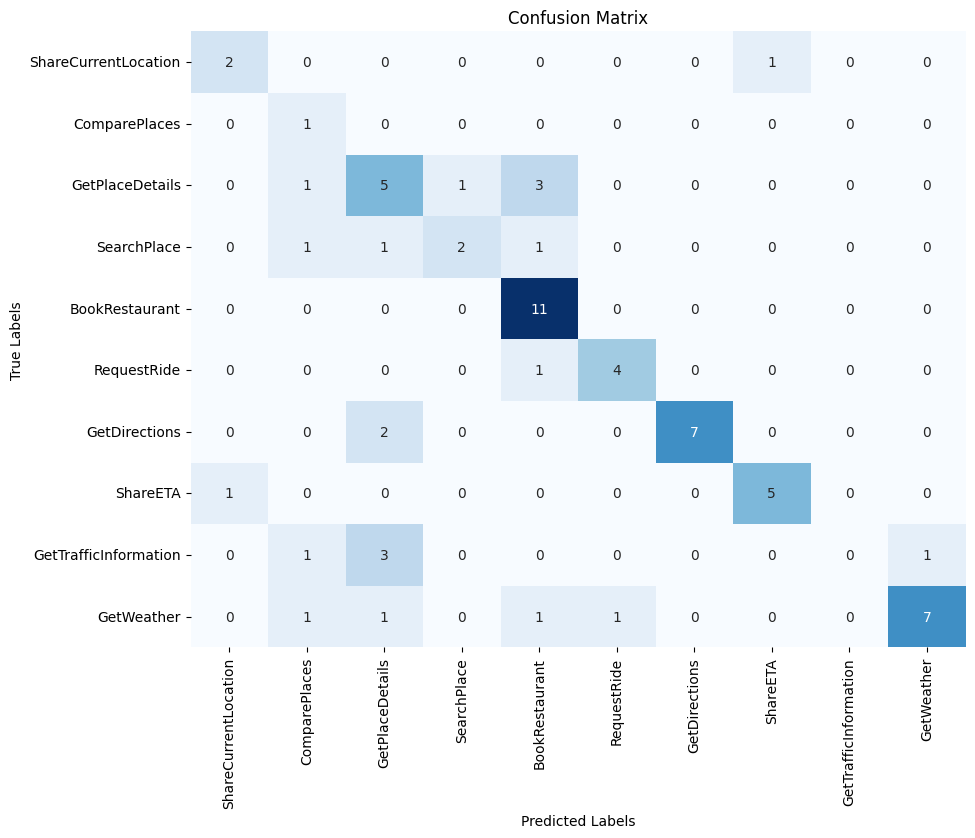

In [33]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix

def plot_rnn_confusion_matrix(model, dataloader, device, class_names):
    """
    Plots the confusion matrix to visualize misclassifications.
    """
    model.eval()  # Set model to evaluation mode
    y_true, y_pred = [], []

    with torch.no_grad():
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)
            lengths = (texts != vocab["<PAD>"]).sum(dim=1).cpu()  # Get actual lengths

            # Get model predictions
            outputs = model(texts, lengths)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Call the confusion matrix function
plot_rnn_confusion_matrix(model, val_loader, device, class_names)

In [34]:
import pickle

# Save the vocabulary dictionary as 'vocab.pickle'
with open("vocab.pickle", "wb") as f:
    pickle.dump(vocab, f)
print("Saved vocab.pickle")

# Save the intent labels dictionary as 'intents_labels.pickle'
with open("intents_labels.pickle", "wb") as f:
    pickle.dump(intent_labels, f)
print("Saved intents_labels.pickle")

# Save the trained model's state dictionary as 'CVNL_RNN.pth'
torch.save(model.state_dict(), "CVNL_RNN.pth")
print("Saved CVNL_RNN.pth")


Saved vocab.pickle
Saved intents_labels.pickle
Saved CVNL_RNN.pth
